In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/공간정보활용 공모전/

/content/drive/.shortcut-targets-by-id/12CdYaiaXminsUG-MrYvqDyVBDHcUxd6B/공간정보활용 공모전


In [ ]:
import pandas as pd
import numpy as np
import gabojago_model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys

from torchvision import transforms , datasets
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
wantRandom = False
if wantRandom is False:
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  torch.cuda.manual_seed_all(0)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

# Data Load


In [ ]:
#npy파일 불러오기
adj_X_file = '/content/drive/MyDrive/공간정보활용 공모전/양평군/adj_X_npy_file.npy'
adj_Y_file = '/content/drive/MyDrive/공간정보활용 공모전/양평군/adj_Y_npy_file.npy'
yp_X_file = '/content/drive/MyDrive/공간정보활용 공모전/양평군/test_X_npy_file.npy'
yp_Y_file = '/content/drive/MyDrive/공간정보활용 공모전/양평군/test_Y_npy_file.npy'
adj_X_np_load = np.load(adj_X_file)
adj_Y_np_load = np.load(adj_Y_file)
yp_X_np_load = np.load(yp_X_file)
yp_Y_np_load = np.load(yp_Y_file)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#numpy Array⇒Tensor
#device type이 'cuda'인 tensor 완성
adj_X = torch.from_numpy(adj_X_np_load).to(device)
adj_Y = torch.from_numpy(adj_Y_np_load).to(device)
yp_X = torch.from_numpy(yp_X_np_load).to(device)
yp_Y = torch.from_numpy(yp_Y_np_load).to(device)

cuda:0


In [ ]:
X = torch.cat([adj_X, yp_X], dim=0).to(device)
Y = torch.cat([adj_Y, yp_Y], dim=0).to(device)

rand_idx = torch.randperm(Y.size(0))
X = X[rand_idx]
Y = Y[rand_idx]

print(adj_Y.size(), yp_Y.size(), Y.size())

torch.Size([26662]) torch.Size([3367]) torch.Size([30029])


# Preprocessing

In [ ]:
normalize = transforms.Compose([transforms.Normalize((0.5), (0.5))])
X = X/255
X = X.float().unsqueeze(1)
X = normalize(X)
Y = Y-1

dataset = TensorDataset(X, Y)

In [ ]:
def make_dataLoader(dataset, batch_size=128):
  # Indices for train /val splits : train_idx , valid_idx
  np.random.seed(0)
  train_ratio = 0.8
  test_ratio = 0.1
  val_ratio = 0.1
  data_size = len(dataset)
  indices = list(range(data_size))
  split_idx1 = int( np.floor(test_ratio*data_size))
  split_idx2 = int( np.floor((test_ratio+val_ratio)*data_size))

  np.random.shuffle(indices)
  train_idx, val_idx, test_idx = indices[split_idx2:], indices[split_idx1:split_idx2], indices[:split_idx1]
  train_sampler = SubsetRandomSampler(train_idx)
  val_sampler = SubsetRandomSampler(val_idx)
  test_sampler = SubsetRandomSampler(test_idx)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True, num_workers=0)
  val_loader = torch.utils.data.DataLoader(dataset, batch_size=1024, sampler=val_sampler, drop_last=False, num_workers=0)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=len(test_idx), sampler=test_sampler, drop_last=False, num_workers=0)

  return train_loader, val_loader, test_loader

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
print(len(train_loader), len(val_loader), len(test_loader))

46 3 1


epoch:  1, train loss: 1.26780224, valid loss: 1.16309130, train acc: 48.93%, valid acc: 51.62%, last lr: 0.0001
epoch:  2, train loss: 1.14675616, valid loss: 1.12813985, train acc: 50.91%, valid acc: 53.40%, last lr: 0.0001
epoch:  3, train loss: 1.09156531, valid loss: 1.06390429, train acc: 56.01%, valid acc: 56.34%, last lr: 0.0001
epoch:  4, train loss: 1.06969860, valid loss: 1.08148682, train acc: 57.46%, valid acc: 55.71%, last lr: 0.0001
epoch:  5, train loss: 1.06131121, valid loss: 1.07470155, train acc: 57.70%, valid acc: 56.65%, last lr: 0.0001
epoch:  6, train loss: 1.05559045, valid loss: 1.04679155, train acc: 58.17%, valid acc: 58.01%, last lr: 0.0001
epoch:  7, train loss: 1.05455359, valid loss: 1.08991075, train acc: 58.55%, valid acc: 56.86%, last lr: 0.0001
epoch:  8, train loss: 1.05243265, valid loss: 1.02451038, train acc: 58.37%, valid acc: 59.06%, last lr: 0.0001
epoch:  9, train loss: 1.04657708, valid loss: 1.08765066, train acc: 58.95%, valid acc: 56.13%,

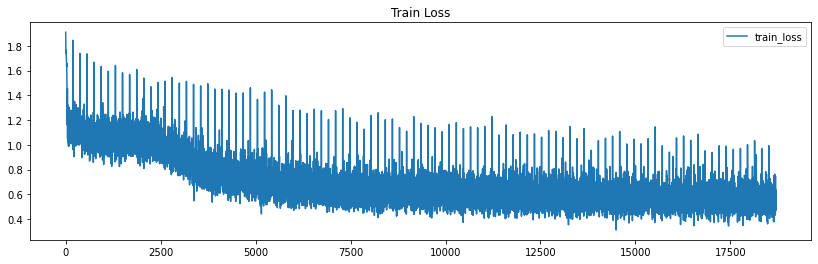

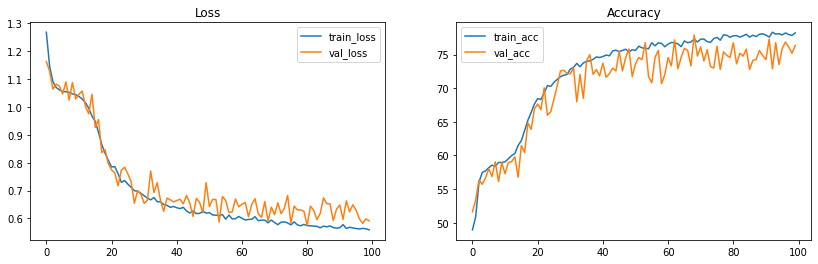

In [ ]:
model41 = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=100, lr=10**(-4), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model41.train_transform_augmentation = transforms.Compose([])
model41.train()
model41.visualizeHist()

## Batch Size & Learing Rate

epoch:  1, train loss: 1.26342588, valid loss: 1.14545774, train acc: 49.21%, valid acc: 52.77%, last lr: 0.0001
epoch:  2, train loss: 1.15279838, valid loss: 1.15585446, train acc: 50.99%, valid acc: 51.73%, last lr: 0.0001
epoch:  3, train loss: 1.12524528, valid loss: 1.14150465, train acc: 53.06%, valid acc: 52.36%, last lr: 0.0001
epoch:  4, train loss: 1.07900033, valid loss: 1.04821312, train acc: 57.02%, valid acc: 58.43%, last lr: 0.0001
epoch:  5, train loss: 1.07025881, valid loss: 1.04280853, train acc: 57.54%, valid acc: 56.75%, last lr: 0.0001
epoch:  6, train loss: 1.06293070, valid loss: 1.09593904, train acc: 58.14%, valid acc: 55.71%, last lr: 0.0001
epoch:  7, train loss: 1.05694108, valid loss: 1.05205142, train acc: 58.41%, valid acc: 58.43%, last lr: 0.0001
epoch:  8, train loss: 1.05418078, valid loss: 1.10700941, train acc: 58.56%, valid acc: 55.39%, last lr: 0.0001
epoch:  9, train loss: 1.04981350, valid loss: 1.01837456, train acc: 58.85%, valid acc: 60.42%,

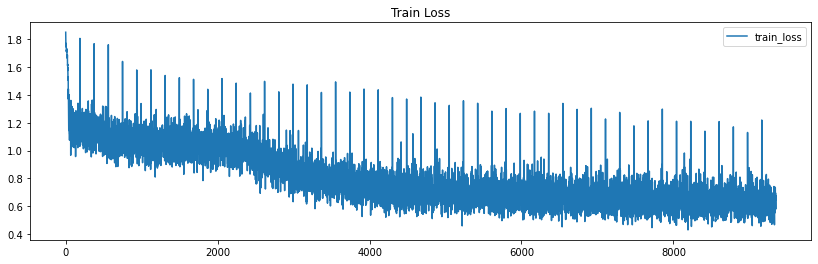

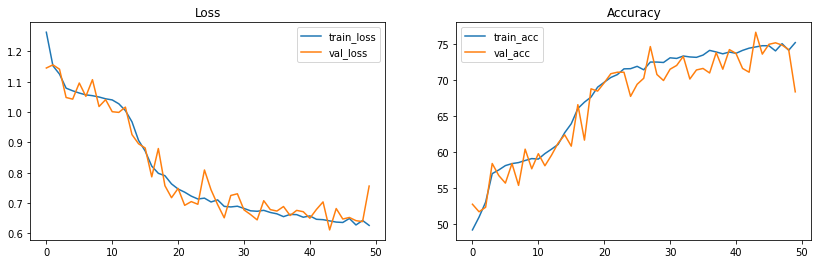

epoch:  1, train loss: 1.40160696, valid loss: 1.14028025, train acc: 43.59%, valid acc: 51.73%, last lr: 0.0001
epoch:  2, train loss: 1.15814196, valid loss: 1.11379969, train acc: 50.76%, valid acc: 53.40%, last lr: 0.0001
epoch:  3, train loss: 1.14350808, valid loss: 1.11943185, train acc: 50.82%, valid acc: 52.15%, last lr: 0.0001
epoch:  4, train loss: 1.11832308, valid loss: 1.09806848, train acc: 53.97%, valid acc: 55.18%, last lr: 0.0001
epoch:  5, train loss: 1.08873850, valid loss: 1.11373460, train acc: 56.50%, valid acc: 54.24%, last lr: 0.0001
epoch:  6, train loss: 1.07418309, valid loss: 1.07470238, train acc: 57.08%, valid acc: 55.92%, last lr: 0.0001
epoch:  7, train loss: 1.06630503, valid loss: 1.08949780, train acc: 57.76%, valid acc: 55.39%, last lr: 0.0001
epoch:  8, train loss: 1.06544051, valid loss: 1.06601095, train acc: 57.61%, valid acc: 57.07%, last lr: 0.0001
epoch:  9, train loss: 1.06452909, valid loss: 1.11431098, train acc: 57.77%, valid acc: 56.86%,

KeyboardInterrupt: ignored

In [ ]:
batch_size = 128
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model41 = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=50, lr=10**(-4), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model41.train_transform_augmentation = transforms.Compose([])
model41.train()
model41.visualizeHist()

epoch:  1, train loss: 1.25881320, valid loss: 1.11550486, train acc: 47.57%, valid acc: 52.25%, last lr: 0.0003
epoch:  2, train loss: 1.15144970, valid loss: 1.10923409, train acc: 51.37%, valid acc: 54.55%, last lr: 0.0003
epoch:  3, train loss: 1.08589066, valid loss: 1.08447313, train acc: 56.54%, valid acc: 55.50%, last lr: 0.0003
epoch:  4, train loss: 1.06469690, valid loss: 1.07044899, train acc: 57.86%, valid acc: 54.66%, last lr: 0.0003
epoch:  5, train loss: 1.06081491, valid loss: 1.12388337, train acc: 57.99%, valid acc: 55.08%, last lr: 0.0003
epoch:  6, train loss: 1.05989643, valid loss: 1.04735291, train acc: 57.98%, valid acc: 57.49%, last lr: 0.0003
epoch:  7, train loss: 1.04673521, valid loss: 1.01633489, train acc: 58.49%, valid acc: 58.64%, last lr: 0.0003
epoch:  8, train loss: 1.04150903, valid loss: 1.00584829, train acc: 58.55%, valid acc: 58.32%, last lr: 0.0003
epoch:  9, train loss: 1.03701380, valid loss: 1.00523877, train acc: 58.80%, valid acc: 58.01%,

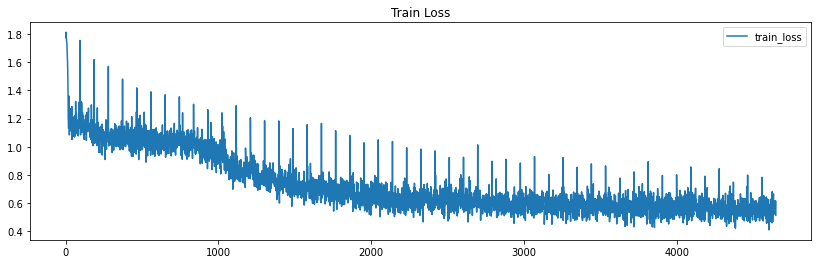

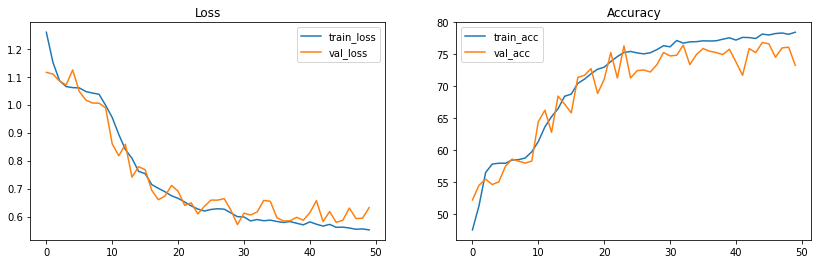

In [ ]:
batch_size = 256
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model41 = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=50, lr=10**(-3.5), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model41.train_transform_augmentation = transforms.Compose([])
model41.train()
model41.visualizeHist()
#lr 0.0002가 적당할듯

epoch:  1, train loss: 1.26482109, valid loss: 1.15436220, train acc: 45.37%, valid acc: 51.41%, last lr: 0.001
epoch:  2, train loss: 1.14648680, valid loss: 1.10043120, train acc: 52.19%, valid acc: 53.51%, last lr: 0.001
epoch:  3, train loss: 1.09096826, valid loss: 1.05612910, train acc: 56.71%, valid acc: 56.86%, last lr: 0.001
epoch:  4, train loss: 1.07210519, valid loss: 1.10492277, train acc: 57.28%, valid acc: 52.88%, last lr: 0.001
epoch:  5, train loss: 1.06278827, valid loss: 1.06290674, train acc: 57.84%, valid acc: 56.65%, last lr: 0.001
epoch:  6, train loss: 1.05751994, valid loss: 1.06865859, train acc: 57.89%, valid acc: 54.66%, last lr: 0.001
epoch:  7, train loss: 1.06183973, valid loss: 1.08223176, train acc: 57.66%, valid acc: 53.82%, last lr: 0.001
epoch:  8, train loss: 1.05256584, valid loss: 1.04323161, train acc: 58.17%, valid acc: 57.70%, last lr: 0.001
epoch:  9, train loss: 1.02824782, valid loss: 1.06020176, train acc: 58.84%, valid acc: 56.54%, last lr

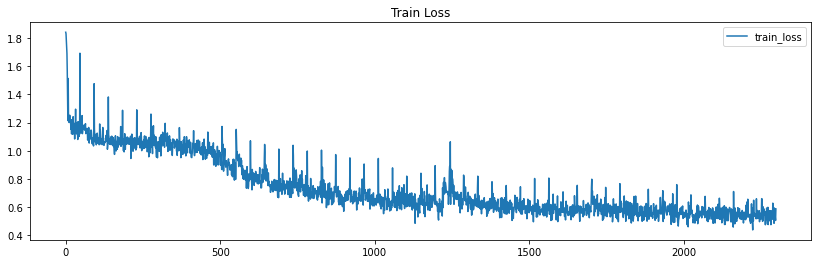

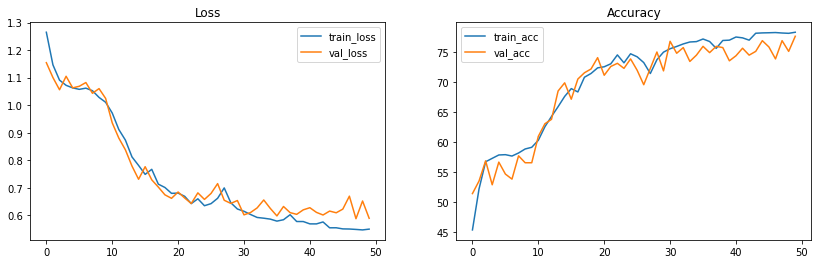

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model41 = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=50, lr=10**(-3), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model41.train_transform_augmentation = transforms.Compose([])
model41.train()
model41.visualizeHist()

## Weight Decay

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)

weight_decay = 0
epoch:  1, train loss: 1.24845156, valid loss: 1.16780984, train acc: 47.72%, valid acc: 50.68%, last lr: 0.001
epoch:  2, train loss: 1.17481489, valid loss: 1.20404446, train acc: 50.97%, valid acc: 47.85%, last lr: 0.001
epoch:  3, train loss: 1.13445677, valid loss: 1.08145201, train acc: 52.97%, valid acc: 57.70%, last lr: 0.001
epoch:  4, train loss: 1.09148990, valid loss: 1.11651325, train acc: 55.64%, valid acc: 55.08%, last lr: 0.001
epoch:  5, train loss: 1.06934008, valid loss: 1.05110991, train acc: 57.17%, valid acc: 57.07%, last lr: 0.001
epoch:  6, train loss: 1.05608916, valid loss: 1.05821145, train acc: 57.86%, valid acc: 58.64%, last lr: 0.001
epoch:  7, train loss: 1.05814427, valid loss: 1.04064143, train acc: 57.26%, valid acc: 59.16%, last lr: 0.001
epoch:  8, train loss: 1.04933252, valid loss: 1.06262147, train acc: 58.14%, valid acc: 57.59%, last lr: 0.001
epoch:  9, train loss: 1.03442971, valid loss: 1.06533873, train acc: 58.90%, valid acc

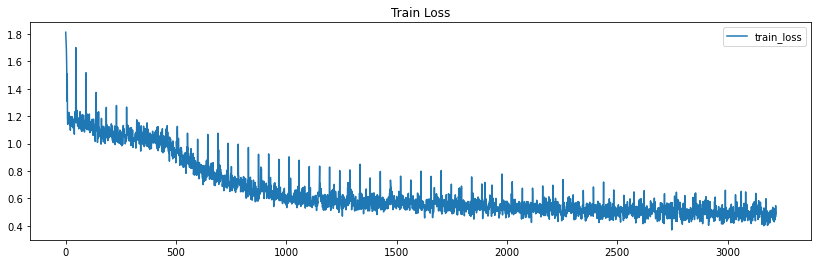

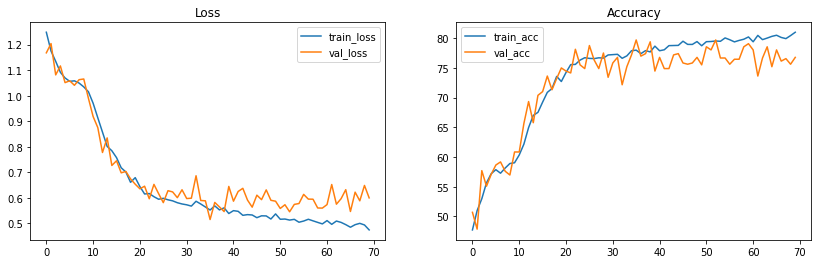

In [ ]:
print('weight_decay = 0')
model41 = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=70, lr=10**(-3), momentum=0.9, weight_decay=0, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model41.train_transform_augmentation = transforms.Compose([])
model41.train()
model41.visualizeHist()

weight_decay = 1e-7
epoch:  1, train loss: 1.26263387, valid loss: 1.12983644, train acc: 47.10%, valid acc: 51.94%, last lr: 0.001
epoch:  2, train loss: 1.11961329, valid loss: 1.06453836, train acc: 54.38%, valid acc: 59.90%, last lr: 0.001
epoch:  3, train loss: 1.08022077, valid loss: 1.06024849, train acc: 56.91%, valid acc: 58.12%, last lr: 0.001
epoch:  4, train loss: 1.07380615, valid loss: 1.06269383, train acc: 57.23%, valid acc: 55.50%, last lr: 0.001
epoch:  5, train loss: 1.06805358, valid loss: 1.08029580, train acc: 57.34%, valid acc: 56.86%, last lr: 0.001
epoch:  6, train loss: 1.06474117, valid loss: 1.00641656, train acc: 57.79%, valid acc: 60.42%, last lr: 0.001
epoch:  7, train loss: 1.04793660, valid loss: 1.06253314, train acc: 57.97%, valid acc: 58.43%, last lr: 0.001
epoch:  8, train loss: 1.04513509, valid loss: 1.04766583, train acc: 57.87%, valid acc: 57.38%, last lr: 0.001
epoch:  9, train loss: 1.02739002, valid loss: 1.02446032, train acc: 58.46%, valid 

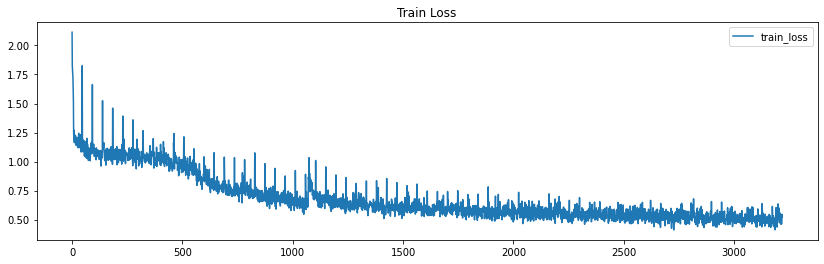

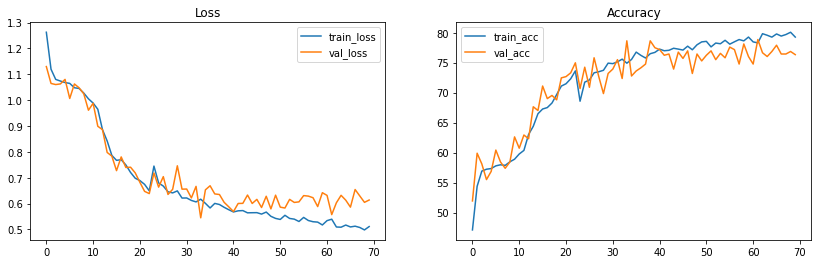

In [ ]:
print('weight_decay = 1e-7')
model41 = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=70, lr=10**(-3), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model41.train_transform_augmentation = transforms.Compose([])
model41.train()
model41.visualizeHist()

weight_decay = 1e-6
epoch:  1, train loss: 1.26071319, valid loss: 1.18351698, train acc: 45.84%, valid acc: 51.83%, last lr: 0.001
epoch:  2, train loss: 1.15462080, valid loss: 1.10380948, train acc: 51.24%, valid acc: 56.54%, last lr: 0.001
epoch:  3, train loss: 1.08189621, valid loss: 1.07815528, train acc: 57.24%, valid acc: 56.54%, last lr: 0.001
epoch:  4, train loss: 1.07068144, valid loss: 1.04216194, train acc: 57.60%, valid acc: 57.49%, last lr: 0.001
epoch:  5, train loss: 1.06394315, valid loss: 1.07192564, train acc: 57.96%, valid acc: 56.34%, last lr: 0.001
epoch:  6, train loss: 1.05586810, valid loss: 1.05518830, train acc: 58.12%, valid acc: 56.34%, last lr: 0.001
epoch:  7, train loss: 1.05233735, valid loss: 1.08937526, train acc: 57.98%, valid acc: 58.64%, last lr: 0.001
epoch:  8, train loss: 1.04897345, valid loss: 1.04241955, train acc: 57.86%, valid acc: 55.92%, last lr: 0.001
epoch:  9, train loss: 1.01414648, valid loss: 1.03478241, train acc: 58.74%, valid 

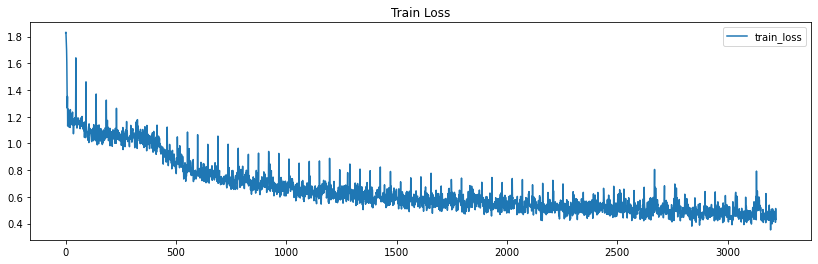

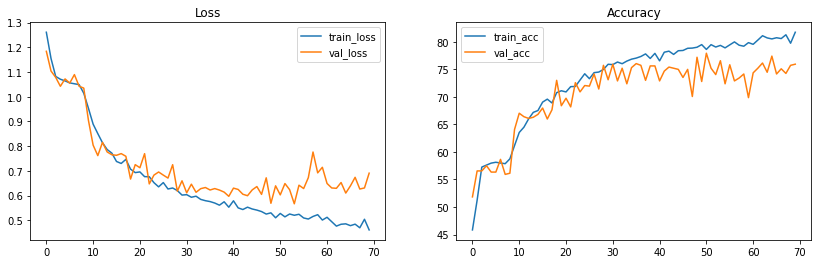

In [ ]:
print('weight_decay = 1e-6')
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=70, lr=10**(-3), momentum=0.9, weight_decay=1e-6, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([])
model.train()
model.visualizeHist()

weight_decay = 1e-5
epoch:  1, train loss: 1.24263594, valid loss: 1.11898184, train acc: 48.19%, valid acc: 53.72%, last lr: 0.001
epoch:  2, train loss: 1.15126307, valid loss: 1.11118019, train acc: 51.70%, valid acc: 54.45%, last lr: 0.001
epoch:  3, train loss: 1.08996887, valid loss: 1.10775793, train acc: 56.33%, valid acc: 54.03%, last lr: 0.001
epoch:  4, train loss: 1.07495643, valid loss: 1.07515240, train acc: 57.00%, valid acc: 56.96%, last lr: 0.001
epoch:  5, train loss: 1.06456102, valid loss: 1.03312528, train acc: 57.79%, valid acc: 59.06%, last lr: 0.001
epoch:  6, train loss: 1.06329552, valid loss: 1.08451378, train acc: 57.66%, valid acc: 56.34%, last lr: 0.001
epoch:  7, train loss: 1.06084643, valid loss: 1.00085068, train acc: 57.48%, valid acc: 59.37%, last lr: 0.001
epoch:  8, train loss: 1.04666581, valid loss: 1.00623345, train acc: 58.27%, valid acc: 59.37%, last lr: 0.001
epoch:  9, train loss: 1.03215138, valid loss: 1.02126193, train acc: 58.89%, valid 

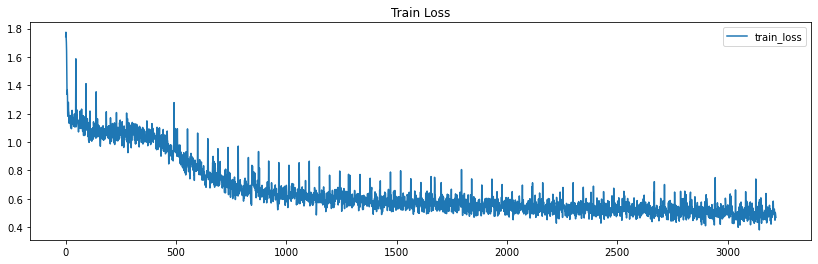

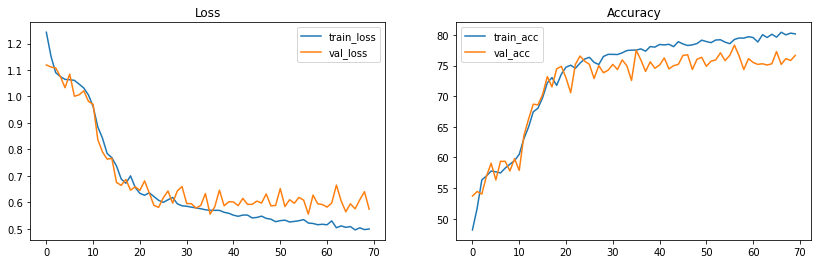

In [ ]:
print('weight_decay = 1e-5')
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=70, lr=10**(-3), momentum=0.9, weight_decay=1e-5, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([])
model.train()
model.visualizeHist()

weight_decay = 1e-4
epoch:  1, train loss: 1.26034729, valid loss: 1.17775249, train acc: 47.45%, valid acc: 50.37%, last lr: 0.001
epoch:  2, train loss: 1.14445200, valid loss: 1.08253646, train acc: 52.23%, valid acc: 56.75%, last lr: 0.001
epoch:  3, train loss: 1.09004554, valid loss: 1.02981114, train acc: 56.49%, valid acc: 58.53%, last lr: 0.001
epoch:  4, train loss: 1.06664889, valid loss: 1.07258642, train acc: 57.55%, valid acc: 57.49%, last lr: 0.001
epoch:  5, train loss: 1.06779091, valid loss: 1.09980822, train acc: 57.90%, valid acc: 56.13%, last lr: 0.001
epoch:  6, train loss: 1.06262394, valid loss: 1.05795527, train acc: 57.76%, valid acc: 57.80%, last lr: 0.001
epoch:  7, train loss: 1.05490985, valid loss: 1.03986120, train acc: 58.18%, valid acc: 57.49%, last lr: 0.001
epoch:  8, train loss: 1.05729163, valid loss: 1.06141520, train acc: 58.12%, valid acc: 57.28%, last lr: 0.001
epoch:  9, train loss: 1.04837728, valid loss: 1.04143083, train acc: 58.49%, valid 

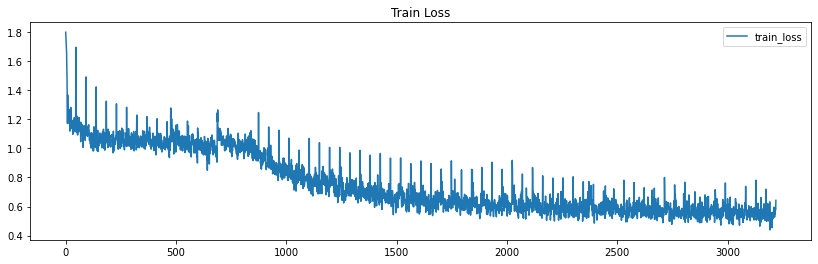

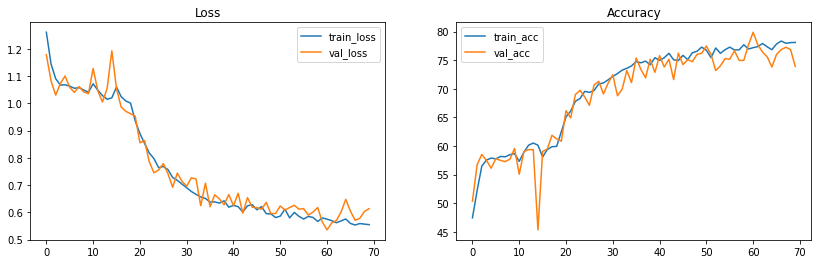

In [ ]:
print('weight_decay = 1e-4')
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=70, lr=10**(-3), momentum=0.9, weight_decay=1e-4, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([])
model.train()
model.visualizeHist()

weight_decay = 1e-3
epoch:  1, train loss: 1.26063417, valid loss: 1.14390898, train acc: 47.09%, valid acc: 52.67%, last lr: 0.001
epoch:  2, train loss: 1.14935362, valid loss: 1.11121058, train acc: 51.56%, valid acc: 55.60%, last lr: 0.001
epoch:  3, train loss: 1.09658130, valid loss: 1.09536803, train acc: 56.29%, valid acc: 54.87%, last lr: 0.001
epoch:  4, train loss: 1.07984103, valid loss: 1.06786096, train acc: 57.09%, valid acc: 55.08%, last lr: 0.001
epoch:  5, train loss: 1.07515727, valid loss: 1.06217444, train acc: 57.24%, valid acc: 57.28%, last lr: 0.001
epoch:  6, train loss: 1.06808961, valid loss: 1.08340561, train acc: 57.32%, valid acc: 57.59%, last lr: 0.001
epoch:  7, train loss: 1.07155082, valid loss: 1.05101800, train acc: 57.11%, valid acc: 57.17%, last lr: 0.001
epoch:  8, train loss: 1.06174799, valid loss: 1.06734550, train acc: 57.56%, valid acc: 56.75%, last lr: 0.001
epoch:  9, train loss: 1.05936072, valid loss: 1.09126055, train acc: 57.85%, valid 

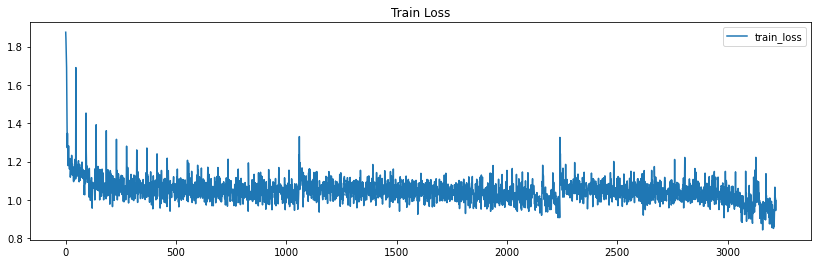

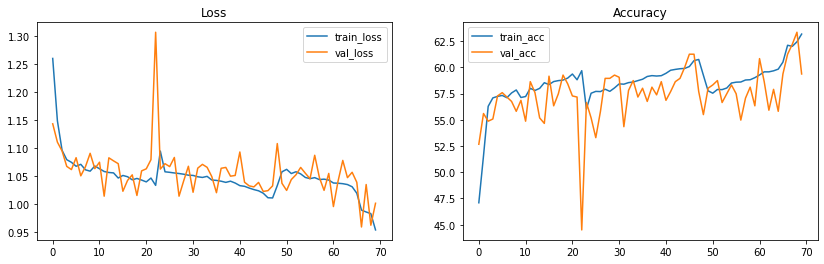

In [ ]:
print('weight_decay = 1e-3')
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=70, lr=10**(-3), momentum=0.9, weight_decay=1e-3, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([])
model.train()
model.visualizeHist()

epoch:  1, train loss: 1.28528555, valid loss: 1.20067203, train acc: 43.26%, valid acc: 49.74%, last lr: 0.0005
epoch:  2, train loss: 1.18181367, valid loss: 1.24715304, train acc: 50.62%, valid acc: 47.02%, last lr: 0.0005
epoch:  3, train loss: 1.17655535, valid loss: 1.16280544, train acc: 50.69%, valid acc: 50.99%, last lr: 0.0005
epoch:  4, train loss: 1.16634991, valid loss: 1.18314266, train acc: 51.06%, valid acc: 50.79%, last lr: 0.0005
epoch:  5, train loss: 1.16619313, valid loss: 1.18385363, train acc: 51.20%, valid acc: 49.74%, last lr: 0.0005
epoch:  6, train loss: 1.11114332, valid loss: 1.14718068, train acc: 53.82%, valid acc: 53.40%, last lr: 0.0005
epoch:  7, train loss: 1.07640877, valid loss: 1.08394265, train acc: 57.04%, valid acc: 58.12%, last lr: 0.0005
epoch:  8, train loss: 1.06396305, valid loss: 1.05723786, train acc: 57.49%, valid acc: 58.74%, last lr: 0.0005
epoch:  9, train loss: 1.05308569, valid loss: 1.06782758, train acc: 58.67%, valid acc: 56.86%,

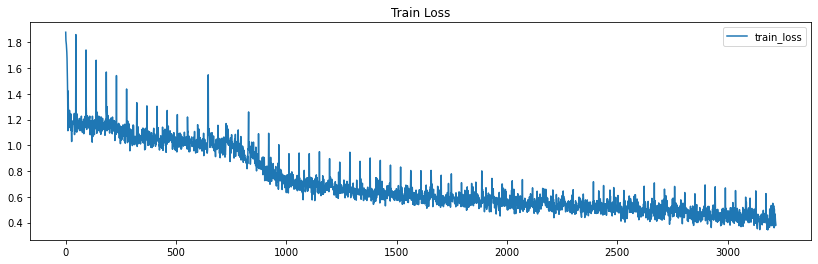

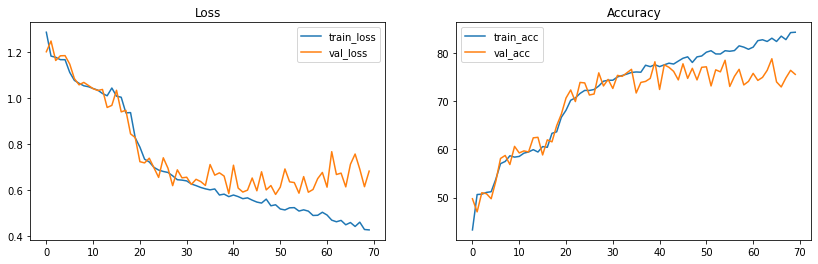

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=5, num_epoch=70, lr=10**(-3.3), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([])
model.train()
model.visualizeHist()

epoch:  1, train loss: 1.28173726, valid loss: 1.17075300, train acc: 49.03%, valid acc: 49.63%, last lr: 0.0006
epoch:  2, train loss: 1.15577807, valid loss: 1.15555584, train acc: 51.05%, valid acc: 52.25%, last lr: 0.0006
epoch:  3, train loss: 1.10718199, valid loss: 1.51027656, train acc: 54.93%, valid acc: 49.11%, last lr: 0.0006
epoch:  4, train loss: 1.08763868, valid loss: 1.57009041, train acc: 56.21%, valid acc: 49.63%, last lr: 0.0006
epoch:  5, train loss: 1.07354672, valid loss: 1.72414696, train acc: 56.60%, valid acc: 50.68%, last lr: 0.0006
epoch:  6, train loss: 1.06227065, valid loss: 1.42078984, train acc: 57.27%, valid acc: 51.62%, last lr: 0.0006
epoch:  7, train loss: 1.07290571, valid loss: 1.33518517, train acc: 56.98%, valid acc: 51.10%, last lr: 0.0006
epoch:  8, train loss: 1.06863602, valid loss: 1.53118157, train acc: 56.91%, valid acc: 51.10%, last lr: 0.0006
epoch:  9, train loss: 1.04429588, valid loss: 1.43485391, train acc: 58.54%, valid acc: 50.68%,

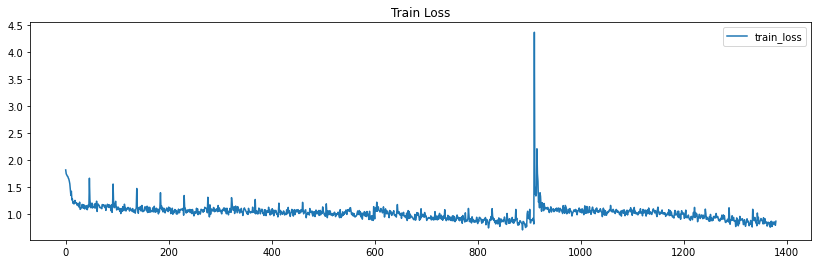

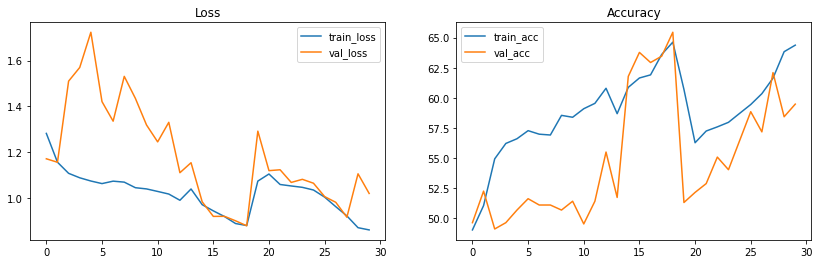

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=30, lr=10**(-3.2), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([
#                                      transforms.RandomChoice([
                                      transforms.RandomRotation(10),
#                                        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2))
#                                       ]),
                                      transforms.Normalize((0.5), (0.5))
])
model.train()
model.visualizeHist()

epoch:  1, train loss: 1.29660910, valid loss: 1.14371359, train acc: 47.95%, valid acc: 53.61%, last lr: 0.0005
epoch:  2, train loss: 1.17981107, valid loss: 1.18869638, train acc: 50.65%, valid acc: 52.77%, last lr: 0.0005
epoch:  3, train loss: 1.17412386, valid loss: 1.20205176, train acc: 50.88%, valid acc: 50.16%, last lr: 0.0005
epoch:  4, train loss: 1.16148169, valid loss: 1.13314664, train acc: 51.26%, valid acc: 52.15%, last lr: 0.0005
epoch:  5, train loss: 1.09249243, valid loss: 1.05095029, train acc: 56.63%, valid acc: 58.01%, last lr: 0.0005
epoch:  6, train loss: 1.07610429, valid loss: 1.10558510, train acc: 56.88%, valid acc: 57.07%, last lr: 0.0005
epoch:  7, train loss: 1.07462429, valid loss: 1.03954554, train acc: 57.34%, valid acc: 58.32%, last lr: 0.0005
epoch:  8, train loss: 1.05103324, valid loss: 1.03749931, train acc: 58.47%, valid acc: 60.52%, last lr: 0.0005
epoch:  9, train loss: 1.04665498, valid loss: 1.08876777, train acc: 58.50%, valid acc: 55.92%,

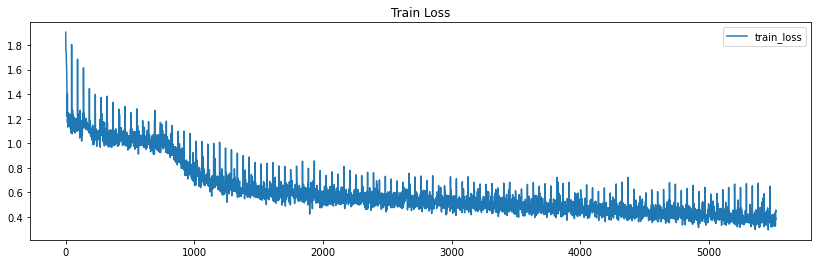

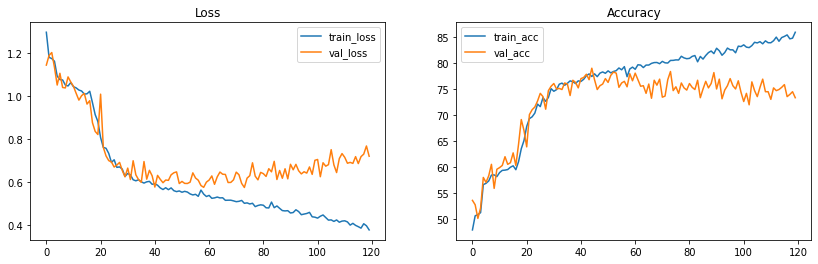

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=120, lr=10**(-3.3), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([])
model.train()
model.visualizeHist()

In [ ]:
model.test()

73.57473500569661

## Data Augmentation

epoch:  1, train loss: 1.31608631, valid loss: 1.17608297, train acc: 45.29%, valid acc: 50.26%, last lr: 0.0005
epoch:  2, train loss: 1.17552362, valid loss: 1.16917777, train acc: 50.71%, valid acc: 51.20%, last lr: 0.0005
epoch:  3, train loss: 1.14393482, valid loss: 1.13276470, train acc: 52.26%, valid acc: 58.64%, last lr: 0.0005
epoch:  4, train loss: 1.17407767, valid loss: 1.18878984, train acc: 52.40%, valid acc: 49.95%, last lr: 0.0005
epoch:  5, train loss: 1.21008997, valid loss: 1.12851095, train acc: 48.10%, valid acc: 51.83%, last lr: 0.0005
epoch:  6, train loss: 1.12367093, valid loss: 1.07528746, train acc: 53.37%, valid acc: 57.49%, last lr: 0.0005
epoch:  7, train loss: 1.08816510, valid loss: 1.10576296, train acc: 56.14%, valid acc: 55.39%, last lr: 0.0005
epoch:  8, train loss: 1.08203006, valid loss: 1.04724312, train acc: 56.50%, valid acc: 58.95%, last lr: 0.0005
epoch:  9, train loss: 1.08773775, valid loss: 1.04935288, train acc: 55.76%, valid acc: 58.64%,

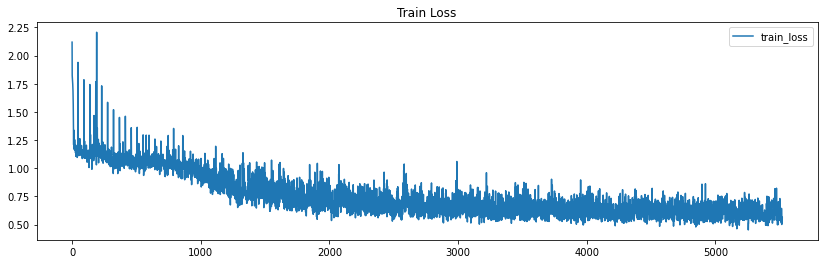

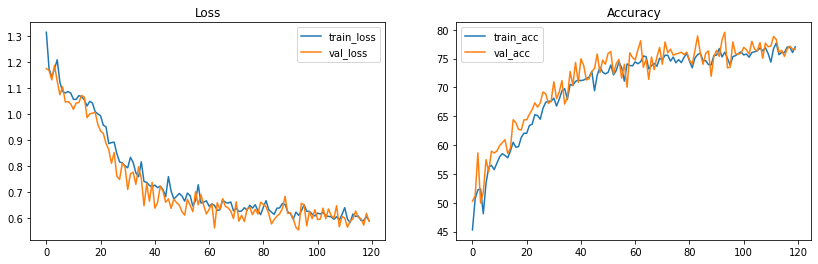

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=120, lr=10**(-3.3), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([
                                      transforms.RandomApply([
                                          transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                          transforms.Normalize((0.5), (0.5))], p=0.3)])
model.train()
model.visualizeHist()

epoch:  1, train loss: 1.24751528, valid loss: 1.21246886, train acc: 47.47%, valid acc: 48.80%, last lr: 0.001
epoch:  2, train loss: 1.16318025, valid loss: 1.16871154, train acc: 50.89%, valid acc: 50.58%, last lr: 0.001
epoch:  3, train loss: 1.16732550, valid loss: 1.08703387, train acc: 50.78%, valid acc: 52.04%, last lr: 0.001
epoch:  4, train loss: 1.15869120, valid loss: 1.13665688, train acc: 51.55%, valid acc: 52.36%, last lr: 0.001
epoch:  5, train loss: 1.12533558, valid loss: 1.09950542, train acc: 53.27%, valid acc: 54.97%, last lr: 0.001
epoch:  6, train loss: 1.11263085, valid loss: 1.07350266, train acc: 55.00%, valid acc: 58.74%, last lr: 0.001
epoch:  7, train loss: 1.11995482, valid loss: 1.04732311, train acc: 54.56%, valid acc: 58.64%, last lr: 0.001
epoch:  8, train loss: 1.06822904, valid loss: 1.07667959, train acc: 57.10%, valid acc: 58.64%, last lr: 0.001
epoch:  9, train loss: 1.07247855, valid loss: 1.05261981, train acc: 56.31%, valid acc: 59.79%, last lr

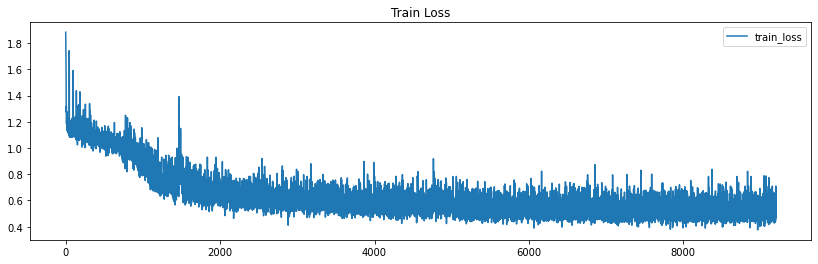

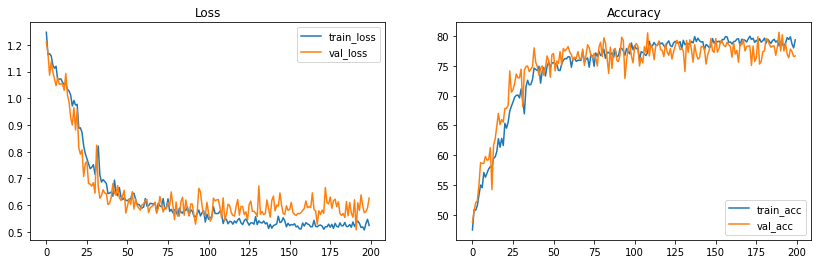

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=200, lr=10**(-3), momentum=0.9, weight_decay=1e-6, lr_decay=10**(-0.5), decay_iter=[5000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([
                                      transforms.RandomApply([
                                          transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                          transforms.Normalize((0.5), (0.5))], p=0.3)])
model.train()
model.visualizeHist()

In [ ]:
torch.save(model.model, 'model.pth')

# Final Model

epoch:  1, train loss: 1.25136080, valid loss: 1.15698540, train acc: 47.76%, valid acc: 52.98%, last lr: 0.001
epoch:  2, train loss: 1.17002593, valid loss: 1.14549196, train acc: 50.87%, valid acc: 52.25%, last lr: 0.001
epoch:  3, train loss: 1.16936364, valid loss: 1.17599893, train acc: 50.82%, valid acc: 51.31%, last lr: 0.001
epoch:  4, train loss: 1.15307955, valid loss: 1.14710855, train acc: 51.26%, valid acc: 50.26%, last lr: 0.001
epoch:  5, train loss: 1.10017013, valid loss: 1.02975738, train acc: 55.70%, valid acc: 60.10%, last lr: 0.001
epoch:  6, train loss: 1.09767644, valid loss: 1.13532078, train acc: 57.00%, valid acc: 53.72%, last lr: 0.001
epoch:  7, train loss: 1.07024853, valid loss: 1.09659719, train acc: 57.35%, valid acc: 55.08%, last lr: 0.001
epoch:  8, train loss: 1.07908106, valid loss: 1.05528438, train acc: 57.15%, valid acc: 59.48%, last lr: 0.001
epoch:  9, train loss: 1.09160708, valid loss: 1.01464772, train acc: 55.99%, valid acc: 58.53%, last lr

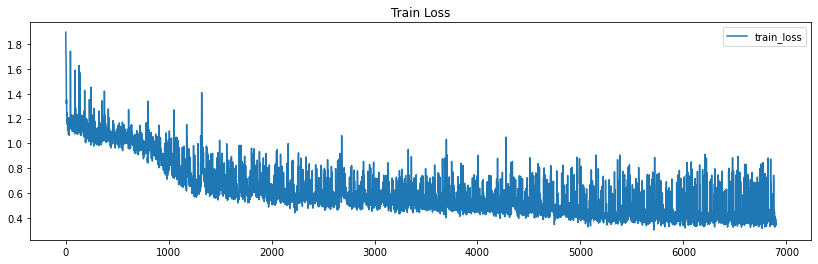

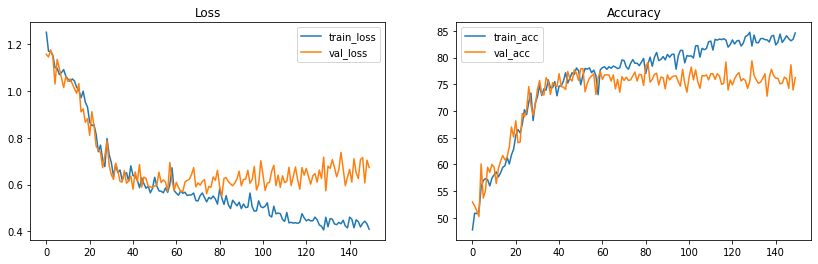

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=150, lr=10**(-3), momentum=0.9, weight_decay=1e-6, lr_decay=10**(-0.5), decay_iter=[5000], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([
                                      transforms.RandomApply([
                                          transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                          transforms.Normalize((0.5), (0.5))], p=0.1)])
model.train()
model.visualizeHist()

In [ ]:
model.test()

72.2185287475586

In [ ]:
torch.save(model.model, f'model{0}.pth')

epoch:  1, train loss: 1.28644460, valid loss: 1.15594232, train acc: 48.51%, valid acc: 49.01%, last lr: 0.0005
epoch:  2, train loss: 1.16416729, valid loss: 1.13066292, train acc: 51.16%, valid acc: 51.52%, last lr: 0.0005
epoch:  3, train loss: 1.13879447, valid loss: 1.10387659, train acc: 52.01%, valid acc: 56.02%, last lr: 0.0005
epoch:  4, train loss: 1.07711648, valid loss: 1.10321844, train acc: 57.00%, valid acc: 59.16%, last lr: 0.0005
epoch:  5, train loss: 1.06727185, valid loss: 1.11191952, train acc: 57.43%, valid acc: 56.13%, last lr: 0.0005
epoch:  6, train loss: 1.05835131, valid loss: 1.02689052, train acc: 57.57%, valid acc: 60.84%, last lr: 0.0005
epoch:  7, train loss: 1.05300818, valid loss: 1.03228605, train acc: 58.13%, valid acc: 60.73%, last lr: 0.0005
epoch:  8, train loss: 1.04794898, valid loss: 1.05640638, train acc: 58.53%, valid acc: 59.27%, last lr: 0.0005
epoch:  9, train loss: 1.04207430, valid loss: 1.02278626, train acc: 58.64%, valid acc: 63.66%,

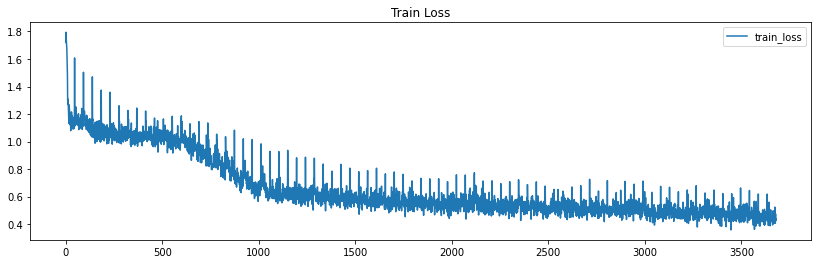

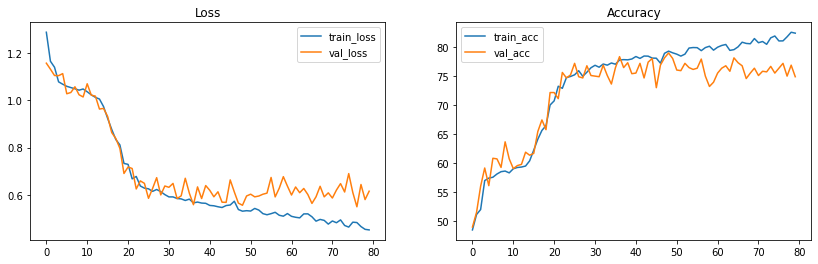

Test accuracy is 72.62%.
epoch:  1, train loss: 1.28235045, valid loss: 1.18609846, train acc: 47.52%, valid acc: 49.84%, last lr: 0.0005
epoch:  2, train loss: 1.18530183, valid loss: 1.15598869, train acc: 50.97%, valid acc: 50.58%, last lr: 0.0005
epoch:  3, train loss: 1.18250685, valid loss: 1.14421022, train acc: 51.49%, valid acc: 51.52%, last lr: 0.0005
epoch:  4, train loss: 1.14628516, valid loss: 1.06126678, train acc: 52.07%, valid acc: 59.48%, last lr: 0.0005
epoch:  5, train loss: 1.11384748, valid loss: 1.12742627, train acc: 55.04%, valid acc: 58.32%, last lr: 0.0005
epoch:  6, train loss: 1.08686033, valid loss: 1.02899361, train acc: 56.42%, valid acc: 58.95%, last lr: 0.0005
epoch:  7, train loss: 1.06451215, valid loss: 1.03162920, train acc: 57.54%, valid acc: 59.58%, last lr: 0.0005
epoch:  8, train loss: 1.05978743, valid loss: 1.00459826, train acc: 57.93%, valid acc: 62.41%, last lr: 0.0005
epoch:  9, train loss: 1.05671873, valid loss: 1.03896356, train acc: 5

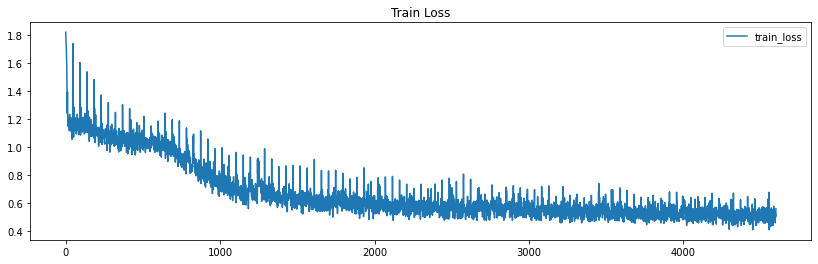

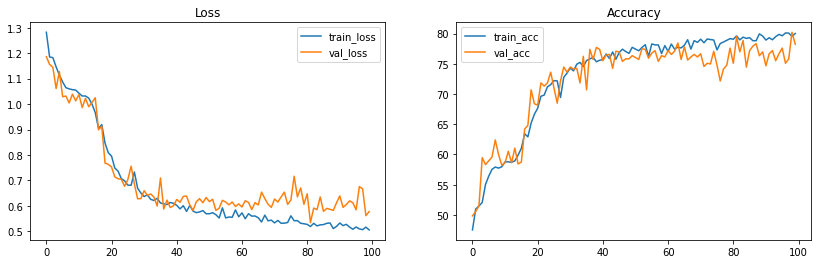

Test accuracy is 72.75%.
epoch:  1, train loss: 1.31664189, valid loss: 1.18770874, train acc: 44.90%, valid acc: 50.16%, last lr: 0.0005
epoch:  2, train loss: 1.17486542, valid loss: 1.16458476, train acc: 50.78%, valid acc: 49.42%, last lr: 0.0005
epoch:  3, train loss: 1.12675235, valid loss: 1.08325243, train acc: 52.71%, valid acc: 58.74%, last lr: 0.0005
epoch:  4, train loss: 1.08557690, valid loss: 1.05284739, train acc: 56.81%, valid acc: 60.00%, last lr: 0.0005
epoch:  5, train loss: 1.07135591, valid loss: 1.08319747, train acc: 56.93%, valid acc: 55.60%, last lr: 0.0005
epoch:  6, train loss: 1.06836625, valid loss: 1.03152084, train acc: 57.83%, valid acc: 60.42%, last lr: 0.0005
epoch:  7, train loss: 1.06204654, valid loss: 1.02656114, train acc: 57.85%, valid acc: 60.84%, last lr: 0.0005
epoch:  8, train loss: 1.05796556, valid loss: 1.06571233, train acc: 58.08%, valid acc: 56.54%, last lr: 0.0005
epoch:  9, train loss: 1.05554225, valid loss: 1.09539080, train acc: 5

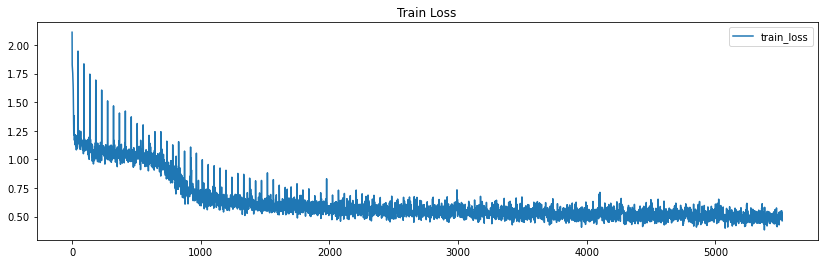

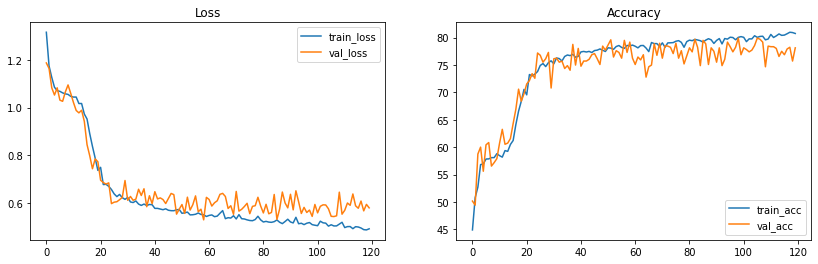

Test accuracy is 75.02%.
epoch:  1, train loss: 1.30642763, valid loss: 1.16655529, train acc: 46.26%, valid acc: 50.37%, last lr: 0.0005
epoch:  2, train loss: 1.16243610, valid loss: 1.15322304, train acc: 51.08%, valid acc: 52.04%, last lr: 0.0005
epoch:  3, train loss: 1.12928024, valid loss: 1.09182239, train acc: 53.23%, valid acc: 54.87%, last lr: 0.0005
epoch:  4, train loss: 1.08387656, valid loss: 1.06862807, train acc: 56.42%, valid acc: 55.08%, last lr: 0.0005
epoch:  5, train loss: 1.07130720, valid loss: 1.07339907, train acc: 57.37%, valid acc: 58.32%, last lr: 0.0005
epoch:  6, train loss: 1.07236627, valid loss: 1.08748603, train acc: 57.01%, valid acc: 57.70%, last lr: 0.0005
epoch:  7, train loss: 1.05809402, valid loss: 1.06437254, train acc: 57.70%, valid acc: 59.27%, last lr: 0.0005
epoch:  8, train loss: 1.05876483, valid loss: 1.04519832, train acc: 57.55%, valid acc: 58.43%, last lr: 0.0005
epoch:  9, train loss: 1.05092822, valid loss: 1.04838169, train acc: 5

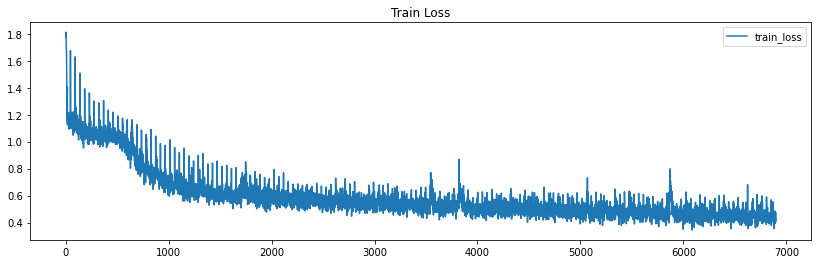

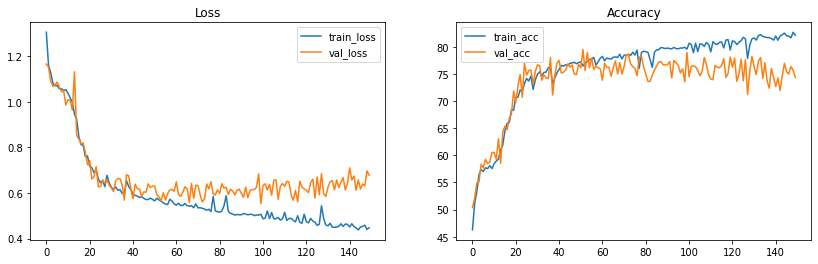

Test accuracy is 74.65%.


In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
epoch_list = [80, 100, 120, 150]
for i in range(len(epoch_list)):
  print('='*100)
  model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=epoch_list[i], lr=10**(-3.3), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
  model.train_transform_augmentation = transforms.Compose([])
  model.train()
  model.visualizeHist()
  print(f'Test accuracy is {model.test():.2f}%.')
  torch.save(model.model, f'model{i+1}.pth')

epoch:  1, train loss: 1.28312540, valid loss: 1.13317215, train acc: 48.56%, valid acc: 50.79%, last lr: 0.0005
epoch:  2, train loss: 1.15911706, valid loss: 1.08394480, train acc: 50.68%, valid acc: 53.51%, last lr: 0.0005
epoch:  3, train loss: 1.10057418, valid loss: 1.05028641, train acc: 55.95%, valid acc: 56.34%, last lr: 0.0005
epoch:  4, train loss: 1.09011399, valid loss: 1.05235696, train acc: 56.44%, valid acc: 57.91%, last lr: 0.0005
epoch:  5, train loss: 1.07330550, valid loss: 1.05033267, train acc: 57.31%, valid acc: 57.91%, last lr: 0.0005
epoch:  6, train loss: 1.05786062, valid loss: 1.01356184, train acc: 58.11%, valid acc: 58.43%, last lr: 0.0005
epoch:  7, train loss: 1.05619470, valid loss: 1.01932168, train acc: 58.34%, valid acc: 58.85%, last lr: 0.0005
epoch:  8, train loss: 1.05596668, valid loss: 1.01441383, train acc: 57.94%, valid acc: 60.31%, last lr: 0.0005
epoch:  9, train loss: 1.05822595, valid loss: 1.03335655, train acc: 57.96%, valid acc: 56.34%,

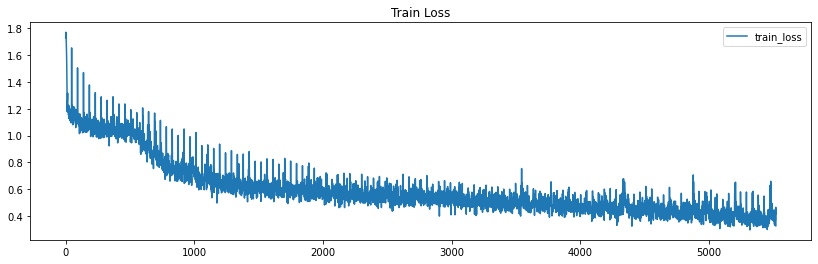

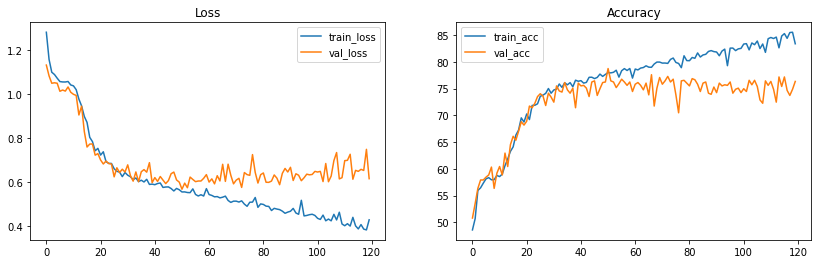

Test accuracy is 74.78%.
epoch:  1, train loss: 1.31271564, valid loss: 1.16062939, train acc: 48.22%, valid acc: 51.20%, last lr: 0.0005
epoch:  2, train loss: 1.17887882, valid loss: 1.12306345, train acc: 50.20%, valid acc: 53.19%, last lr: 0.0005
epoch:  3, train loss: 1.17609510, valid loss: 1.07177830, train acc: 50.23%, valid acc: 56.54%, last lr: 0.0005
epoch:  4, train loss: 1.14924840, valid loss: 1.06699562, train acc: 51.41%, valid acc: 55.18%, last lr: 0.0005
epoch:  5, train loss: 1.09792624, valid loss: 1.02511895, train acc: 56.14%, valid acc: 58.74%, last lr: 0.0005
epoch:  6, train loss: 1.07681158, valid loss: 1.04072344, train acc: 57.29%, valid acc: 57.49%, last lr: 0.0005
epoch:  7, train loss: 1.06404132, valid loss: 1.02862060, train acc: 57.88%, valid acc: 58.01%, last lr: 0.0005
epoch:  8, train loss: 1.06169302, valid loss: 1.01568329, train acc: 58.04%, valid acc: 57.70%, last lr: 0.0005
epoch:  9, train loss: 1.06187457, valid loss: 1.03867447, train acc: 5

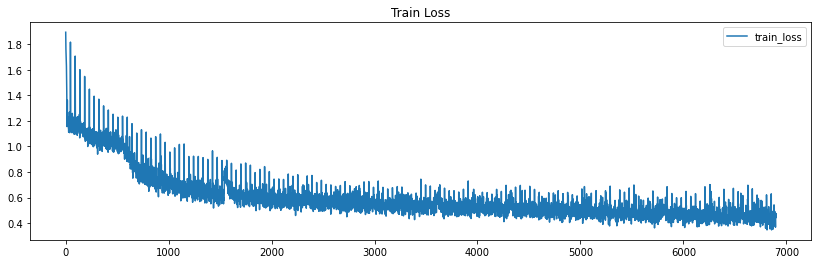

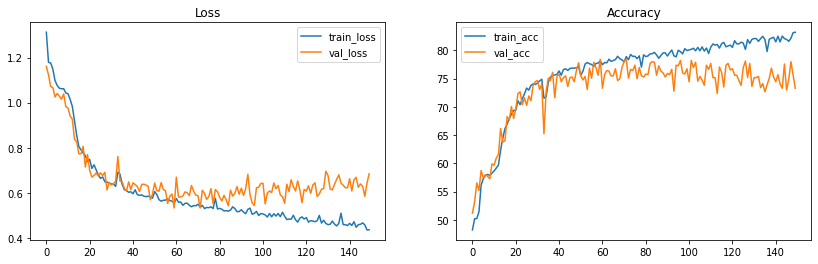

Test accuracy is 73.02%.


In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
epoch_list = [120, 150]
for i in range(len(epoch_list)):
  print('='*100)
  model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=epoch_list[i], lr=10**(-3.3), momentum=0.9, weight_decay=1e-7, lr_decay=0.1, decay_iter=[30000], terminate_train_iter=64000, device=device)
  model.train_transform_augmentation = transforms.Compose([])
  model.train()
  model.visualizeHist()
  print(f'Test accuracy is {model.test():.2f}%.')
  torch.save(model.model, f'model{i+5}.pth')

epoch:  1, train loss: 1.25989846, valid loss: 1.14435160, train acc: 46.80%, valid acc: 53.72%, last lr: 0.001
epoch:  2, train loss: 1.17670752, valid loss: 1.13404405, train acc: 50.85%, valid acc: 51.83%, last lr: 0.001
epoch:  3, train loss: 1.15422189, valid loss: 1.07301557, train acc: 51.36%, valid acc: 57.07%, last lr: 0.001
epoch:  4, train loss: 1.15220184, valid loss: 1.07806730, train acc: 52.71%, valid acc: 55.29%, last lr: 0.001
epoch:  5, train loss: 1.12673848, valid loss: 1.04299641, train acc: 53.01%, valid acc: 55.81%, last lr: 0.001
epoch:  6, train loss: 1.09452979, valid loss: 1.05225897, train acc: 56.14%, valid acc: 54.87%, last lr: 0.001
epoch:  7, train loss: 1.14635143, valid loss: 1.10755491, train acc: 54.17%, valid acc: 54.24%, last lr: 0.001
epoch:  8, train loss: 1.10698839, valid loss: 1.11406982, train acc: 55.99%, valid acc: 54.14%, last lr: 0.001
epoch:  9, train loss: 1.09230370, valid loss: 1.06740355, train acc: 55.85%, valid acc: 55.50%, last lr

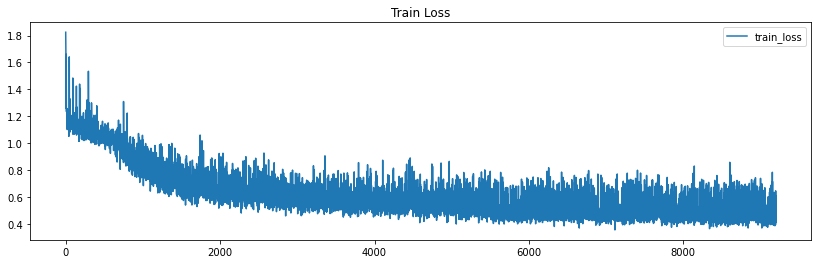

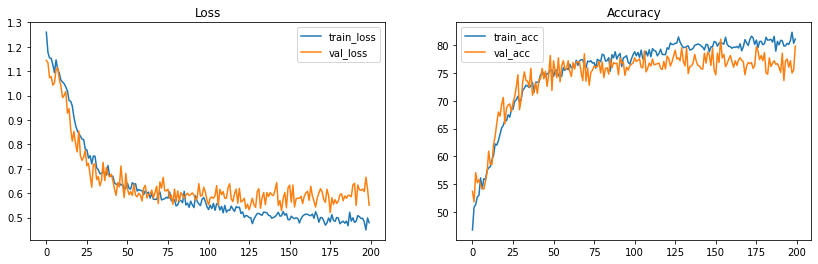

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=200, lr=10**(-3), momentum=0.9, weight_decay=1e-6, lr_decay=10**(-0.5), decay_iter=[5500], terminate_train_iter=64000, device=device)
model.train_transform_augmentation = transforms.Compose([
                                      transforms.RandomApply([
                                        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                        transforms.Normalize((0.5), (0.5))], p=0.2)])
model.train()
model.visualizeHist()

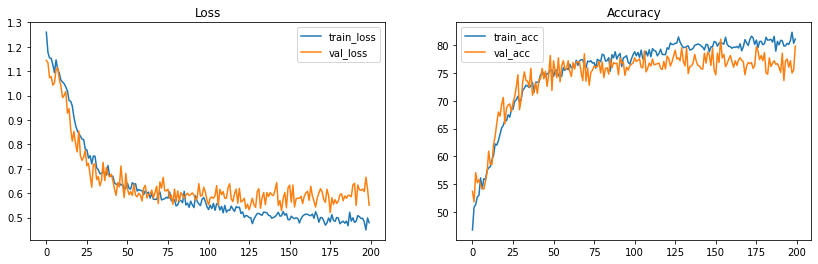

In [ ]:
model.visualizeHist()
model.test()
torch.save(model.model, 'model7.pth')

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=200, lr=10**(-3), momentum=0.9, weight_decay=1e-6, lr_decay=10**(-0.5), decay_iter=[5500], terminate_train_iter=64000, device=device)
model.model = torch.load('model3.pth')
model.test()

75.01666259765625

In [ ]:
batch_size = 512
train_loader, val_loader, test_loader = make_dataLoader(dataset, batch_size)
model = gabojago_model.ResNetforGEO(train_loader, val_loader, test_loader, op="Adam", num_blocks=3, num_epoch=200, lr=10**(-3), momentum=0.9, weight_decay=1e-6, lr_decay=10**(-0.5), decay_iter=[5500], terminate_train_iter=64000, device=device)
model.model = torch.load('model7.pth')
model.test()

77.71485900878906